In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sb
plt.style.use('bmh')

from pandas.plotting import lag_plot, scatter_matrix, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## 1. Load dataset

In [2]:
df = pd.read_csv('base_para_prediccion.csv', parse_dates=['fecha'])
df

,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw
0,SE031G216,2019-01-04 00:00:00+00:00,1,NaN,NaN,NaN,NaN,0.000,56.2,55.627852,0.57,1.02,2,1210767,13.20785
1,SE031G216,2019-01-04 00:00:00+00:00,2,NaN,NaN,NaN,NaN,0.000,56.2,55.376645,0.82,1.48,2,113232,13.20785
2,SE031G216,2019-01-04 00:00:00+00:00,3,NaN,NaN,NaN,NaN,0.000,56.2,59.531891,-3.33,-5.59,2,1089415,13.20785
3,SE031G216,2019-01-04 00:00:00+00:00,4,NaN,NaN,NaN,NaN,0.000,56.2,174.378923,-118.18,-67.77,2,1096867,13.20785
4,SE031G216,2019-01-04 00:00:00+00:00,5,NaN,NaN,NaN,NaN,0.000,56.2,172.820310,-116.62,-67.48,2,1071851,13.20785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112774,SE170T005,2019-06-30 00:00:00+00:00,20,NaN,NaN,NaN,NaN,0.775,44.1,41.362200,2.74,6.62,3,9334786,30.14000
112775,SE170T005,2019-06-30 00:00:00+00:00,21,NaN,NaN,NaN,NaN,0.925,44.1,42.217780,1.88,4.45,3,9353773,30.14000
112776,SE170T005,2019-06-30 00:00:00+00:00,22,NaN,NaN,NaN,NaN,0.975,44.1,42.197451,1.90,4.50,3,9114529,30.14000
112777,SE170T005,2019-06-30 00:00:00+00:00,23,NaN,NaN,NaN,NaN,0.750,44.1,41.473556,2.63,6.34,3,8118728,30.14000


### Meaning of variables

* **nemotecnico_se** = substation code

* **gen_eolica_total_mwh** = wind energy 
* **gen_geotermica_total_mwh** = geothermal energy
* **gen_hidraulica_total_mwh** = hydraulic energy
* **gen_solar_total_mwh** = solar energy
* **gen_termica_total_mwh** = thermal energy

* **cmg_real** = real marginal cost
* **cmg_prog** = programmed marginal cost
* **cmg_desv** = difference between real cost and programmed cost
* **cmg_desv_pct** = percentage of marginal cost desviation

* **n_barras** = number of busbars
* **demanda_mwh** = electrical demand
* **cap_inst_mw** = installed capacity

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112779 entries, 0 to 112778
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype              
---  ------                    --------------   -----              
 0   nemotecnico_se            112779 non-null  object             
 1   fecha                     112779 non-null  datetime64[ns, UTC]
 2   hora                      112779 non-null  int64              
 3   gen_eolica_total_mwh      0 non-null       float64            
 4   gen_geotermica_total_mwh  0 non-null       float64            
 5   gen_hidraulica_total_mwh  34184 non-null   float64            
 6   gen_solar_total_mwh       41818 non-null   float64            
 7   gen_termica_total_mwh     61863 non-null   float64            
 8   cmg_real                  112779 non-null  float64            
 9   cmg_prog                  112779 non-null  float64            
 10  cmg_desv                  112779 non-null  float64            
 11  

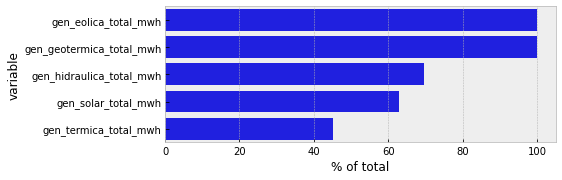

Null values count per variable and percentage of total data 
------------------------------------------------------------
                   variable   count  % of total
0      gen_eolica_total_mwh  112779      100.00
1  gen_geotermica_total_mwh  112779      100.00
2  gen_hidraulica_total_mwh   78595       69.69
3       gen_solar_total_mwh   70961       62.92
4     gen_termica_total_mwh   50916       45.15


In [4]:
def null_values_summary(df):
    counts = df.isnull().sum().sort_values(ascending=False)
    counts_percent = round(counts / len(df) * 100, 2)
    counts_df = pd.DataFrame(counts)
    counts_percent_df = pd.concat([counts_df, counts_percent], axis=1).reset_index()
    counts_percent_df.columns = ['variable', 'count', '% of total']
    data = counts_percent_df[counts_percent_df['count'] > 0]
    # Barplot
    plt.figure(figsize=(7, len(data) / 2))
    sb.barplot(y=data['variable'], 
               x=data['% of total'], 
               orient='h', 
               color='blue')
    plt.show()    
    print('Null values count per variable and percentage of total data', '\n' + '-'*60)
    print(data)
    

null_values_summary(df)

In [5]:
df.nunique()

nemotecnico_se                  29
fecha                          181
hora                            25
gen_eolica_total_mwh             0
gen_geotermica_total_mwh         0
gen_hidraulica_total_mwh     10261
gen_solar_total_mwh          16212
gen_termica_total_mwh         4371
cmg_real                     13848
cmg_prog                     99157
cmg_desv                     18357
cmg_desv_pct                 21339
n_barras                         6
demanda_mwh                 102625
cap_inst_mw                     29
dtype: int64

In [6]:
df.describe()

,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw
count,112779.000000,0.0,0.0,34184.000000,41818.000000,61863.000000,112779.000000,112779.000000,112779.000000,112779.00,112779.000000,1.127790e+05,112779.000000
mean,12.502993,NaN,NaN,38.120053,3.764987,40.583146,61.170058,62.215400,-1.045338,inf,2.331844,6.357056e+07,128.719565
std,6.924090,NaN,NaN,69.838109,12.904388,101.083396,25.414147,25.307759,24.711575,NaN,1.304096,3.948683e+08,167.948649
min,1.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,-1.713131,-562.470000,-3403.97,1.000000,-9.821095e+09,2.989800
25%,7.000000,NaN,NaN,0.849787,0.000000,0.000000,49.130000,49.906745,-3.790000,-7.07,1.000000,7.464800e+05,18.420000
50%,13.000000,NaN,NaN,9.600000,0.000000,0.000000,54.610000,55.420601,-0.310000,-0.58,2.000000,4.507282e+06,51.850000
75%,19.000000,NaN,NaN,40.000000,1.571022,15.960000,63.500000,64.701951,1.670000,2.92,3.000000,1.332345e+07,184.685500
max,25.000000,NaN,NaN,472.000000,86.050000,570.600800,240.360000,610.600000,175.020000,inf,6.000000,1.004240e+10,597.782800


## 2. Some data cleaning...

### a. Check for duplicates

In [7]:
subset = [
    'nemotecnico_se',
    'fecha',
    'hora'
]

bool_mask = df.duplicated(subset=subset)
print('Number of duplicate rows: ', df[bool_mask].shape[0])

Number of duplicate rows:  0


### b. Delete rows where "hora" == 25

In [8]:
df['hora'].value_counts()

1     4698
14    4698
24    4698
23    4698
22    4698
21    4698
20    4698
19    4698
18    4698
17    4698
16    4698
15    4698
13    4698
2     4698
12    4698
11    4698
10    4698
9     4698
8     4698
7     4698
6     4698
5     4698
4     4698
3     4698
25      27
Name: hora, dtype: int64

In [9]:
rows_to_delete = df[df['hora']==25].index.tolist()
df.drop(rows_to_delete, axis=0, inplace=True)

print('Number of rows deleted: {}'.format(len(rows_to_delete)))
print('Number of rows of dataframe after deleting rows: ', df.shape[0])

Number of rows deleted: 27
Number of rows of dataframe after deleting rows:  112752


### c. Change hour "24" to hour "0"

In [10]:
df['hora'] = df['hora'].apply(lambda x: 0 if x==24 else x)

### d. Delete rows of substations that don't have full data

In [11]:
rows_per_se = df['nemotecnico_se'].value_counts()
rows_per_se

SE014T002    4344
SE036T002    4344
SE004T002    4344
SE170T005    4344
SE067T005    4344
SE127T005    4344
SE008G010    4344
SE003T011    4344
SE055T005    4344
SE005T002    4344
SE009T002    4344
SE009G004    4344
SE004L079    4344
SE019T002    4344
SE123G216    4344
SE028T002    4344
SE005T003    4344
SE039R002    4344
SE015R002    4344
SE005R002    4344
SE001T002    4344
SE055T002    4344
SE071T005    3768
SE081T005    3768
SE082T005    3768
SE106G216    3576
SE020G213    2184
SE031G216      96
SE103L123      24
Name: nemotecnico_se, dtype: int64

In [12]:
# Substations to delete
se_to_delete = rows_per_se[rows_per_se < rows_per_se.max()].index.tolist()
print('Substations to delete: ', se_to_delete)
# List of rows to delete from df
rows_to_delete = df[df['nemotecnico_se'].isin(se_to_delete)].index.tolist()
df.drop(rows_to_delete, axis=0, inplace=True)

print('Number of rows deleted: ', len(rows_to_delete))
print('% of rows deleted: ', round((len(rows_to_delete) / df.shape[0]) * 100, 2))
print('Number of rows of dataframe after deleting rows: ', df.shape[0])

Substations to delete:  ['SE071T005', 'SE081T005', 'SE082T005', 'SE106G216', 'SE020G213', 'SE031G216', 'SE103L123']
Number of rows deleted:  17184
% of rows deleted:  17.98
Number of rows of dataframe after deleting rows:  95568


### e. Delete rows with infinite values

In [13]:
df['cmg_desv_pct'].sort_values().tail()

2485     118621.05
45935    118799.58
24210    118815.83
61098    120587.82
29512          inf
Name: cmg_desv_pct, dtype: float64

In [14]:
# rows_to_delete = df[df['cmg_desv_pct']==df['cmg_desv_pct'].max()].index.tolist()
# df.drop(rows_to_delete, axis=0, inplace=True)

# print('Number of rows deleted: ', len(rows_to_delete))

### f. Delete columns that don't have any valid values

In [15]:
columns_to_delete = df.nunique()[df.nunique()==0].index.tolist()

if len(columns_to_delete) > 0:
    df.drop(columns_to_delete, axis=1, inplace=True)
    print('Columns that were deleted: ', columns_to_delete)
else:
    print('No columns were deleted from dataframe...')

Columns that were deleted:  ['gen_eolica_total_mwh', 'gen_geotermica_total_mwh']


## 3. Create new variables

### a. Date-time related variables

In [16]:
# Month
df['mes'] = df['fecha'].dt.month
# Day of month
df['dia'] = df['fecha'].dt.day
# Week of year
df['semana_año'] = df['fecha'].dt.isocalendar().week
# Day of year
df['dia_calendario'] = df['fecha'].dt.dayofyear
# Day of week
df['dia_semana'] = df['fecha'].dt.weekday
# Weekend (1) or Business (0) day
df['fin_semana_si_no'] = df['dia_semana'].map(lambda x: 1 if x in [5,6] else 0)
# Convert "fecha" variable from date to date-time variable adding the "hour" variable
df['fecha'] = df['fecha'] + pd.to_timedelta(df['hora'], unit='H')

### b. Energy related variables

In [17]:
# Fill null values with zero for energy variables
for column in ['gen_hidraulica_total_mwh', 'gen_solar_total_mwh', 'gen_termica_total_mwh']:
    df[column] = df[column].fillna(0)

# Sum of all energy sources
df['gen_total_mwh'] = df['gen_hidraulica_total_mwh'] + df['gen_solar_total_mwh'] + df['gen_termica_total_mwh']

# # Percentage of hydraulic energy
# df['gen_hidraulica_pct'] = 0
# # Percentage of solar energy
# df['gen_solar_pct'] = 0
# # Percentage of thermal energy
# df['gen_termica_pct'] = 0

# for idx,row in df.iterrows():
#     if df.loc[idx, 'gen_total_mwh']!=0:
#         df.loc[idx, 'gen_hidraulica_pct'] = df.loc[idx, 'gen_hidraulica_total_mwh'] / df.loc[idx, 'gen_total_mwh']
#         df.loc[idx, 'gen_solar_pct'] = df.loc[idx, 'gen_solar_total_mwh'] / df.loc[idx, 'gen_total_mwh']
#         df.loc[idx, 'gen_termica_pct'] = df.loc[idx, 'gen_termica_total_mwh'] / df.loc[idx, 'gen_total_mwh']

In [18]:
df.describe()

,hora,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw,mes,dia,semana_año,dia_calendario,dia_semana,fin_semana_si_no,gen_total_mwh
count,95568.000000,95568.000000,95568.000000,95568.000000,95568.000000,95568.000000,95568.000000,95568.0000,95568.000000,9.556800e+04,95568.000000,95568.000000,95568.000000,95568.000000,95568.000000,95568.000000,95568.000000,95568.000000
mean,11.500000,13.557594,1.567683,14.789653,61.977877,62.050798,-0.072909,inf,2.181818,7.310089e+07,137.883873,3.508287,15.602210,13.569061,91.000000,3.016575,0.287293,29.914930
std,6.922223,45.604329,8.740869,44.801259,26.156385,24.816113,23.934591,NaN,1.301627,4.282055e+08,167.399900,1.709969,8.735368,7.462796,52.249675,1.993023,0.452502,60.630600
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-562.470000,-110.4800,1.000000,-9.821095e+09,2.989800,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,5.750000,0.000000,0.000000,0.000000,49.323333,50.183980,-3.250000,-5.9900,1.000000,6.499058e+05,25.942800,2.000000,8.000000,7.000000,46.000000,1.000000,0.000000,0.000000
50%,11.500000,0.000000,0.000000,0.000000,54.750000,55.439038,-0.213333,-0.4000,2.000000,3.465101e+06,59.340500,4.000000,16.000000,14.000000,91.000000,3.000000,0.000000,2.000000
75%,17.250000,0.360190,0.000000,0.525000,64.100000,64.058054,1.620000,2.8175,3.000000,1.285568e+07,184.685500,5.000000,23.000000,20.000000,136.000000,5.000000,1.000000,22.416667
max,23.000000,472.000000,86.050000,226.000000,240.360000,610.600000,175.020000,inf,6.000000,1.004240e+10,597.782800,6.000000,31.000000,26.000000,181.000000,6.000000,1.000000,472.000000


## 4. Exploratory data analysis

### a. Using boxplots

In [19]:
def multiple_boxplots(num_var, cat_var, se_code_list:list=None, rotate_xticks=False):
    if se_code_list is not None:
        data = df[df['nemotecnico_se'].isin(se_code_list)]
    else:
        data = df
        
    n_cats = len(data[cat_var].unique())
    if n_cats <= 3:
        width_fig = 5
    elif (n_cats > 3) & (n_cats < 11):
        width_fig = 10
    else:
        width_fig = 15
    
    plt.figure(figsize=(width_fig,5))
    sb.boxplot(x=cat_var, y=num_var, data=data)
    if rotate_xticks:
        plt.xticks(rotation=45, ha='right')
    plt.show()

In [20]:
cat_vars = [
    'n_barras',
    'mes', 'dia', 'hora', 
    'semana_año', 'dia_semana', 'fin_semana_si_no'
]

num_vars = [
    'cmg_real',
    'cmg_prog',
    'cmg_desv',
    'demanda_mwh'
]

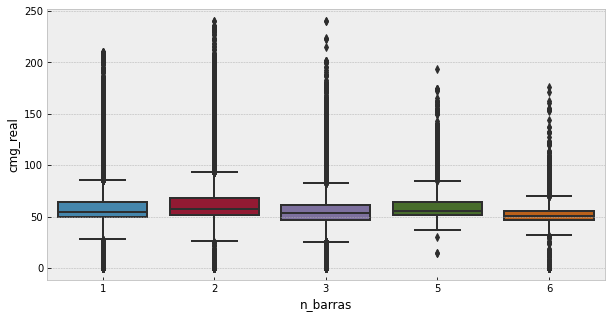

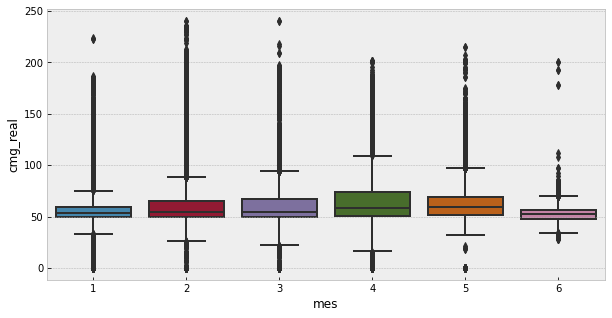

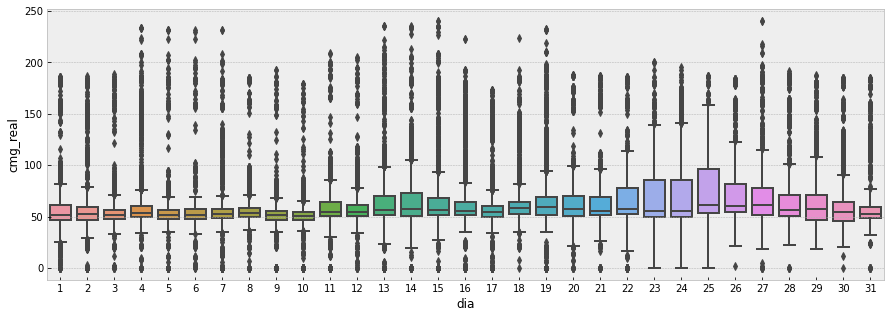

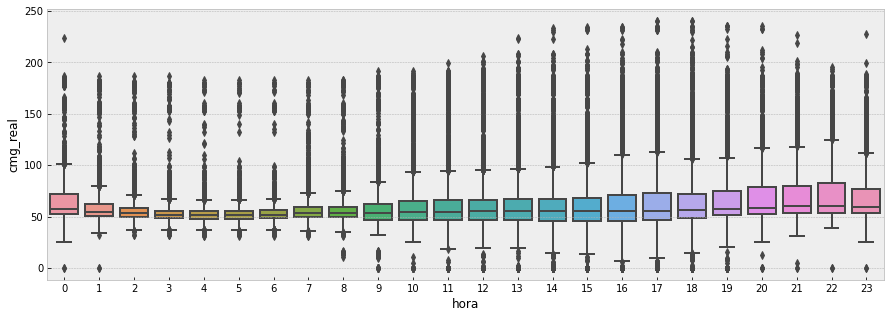

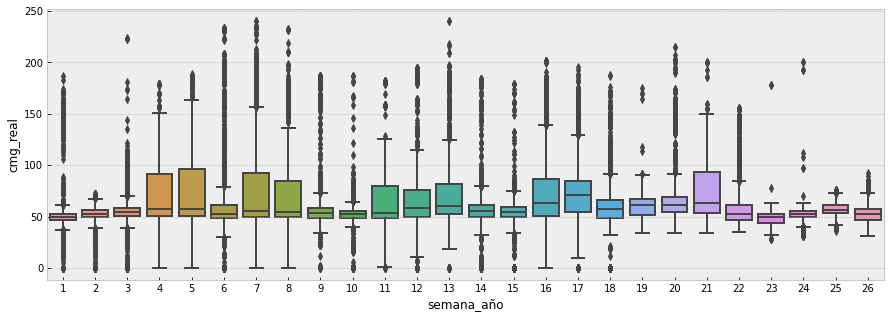

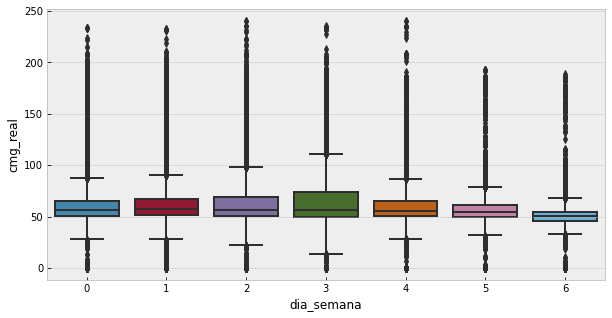

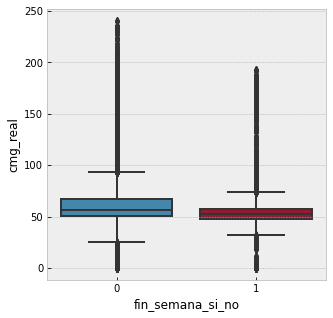

In [21]:
# Variable: 'cmg_real'

for cat_var in cat_vars:
    multiple_boxplots(num_vars[0], cat_var)

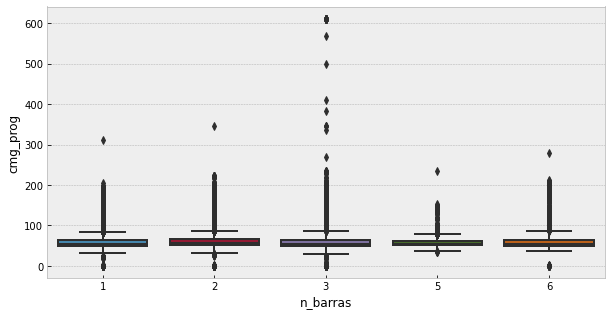

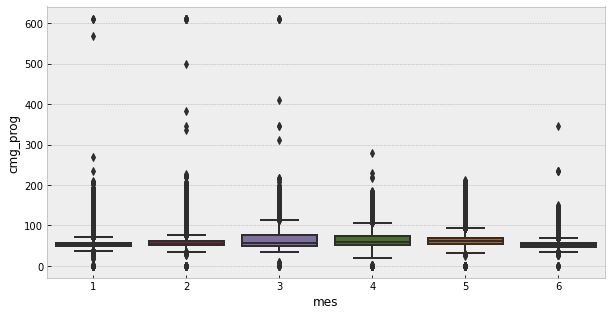

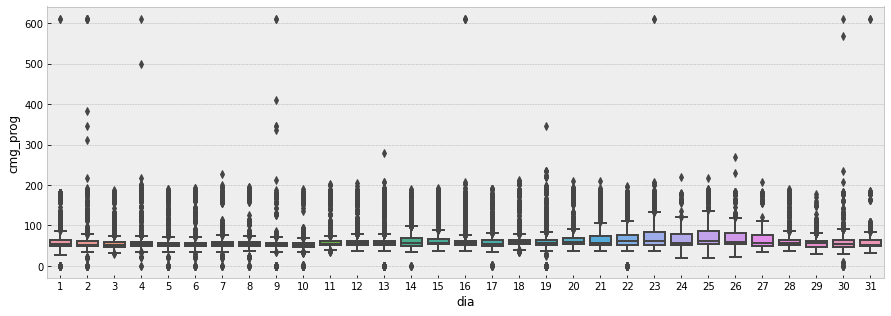

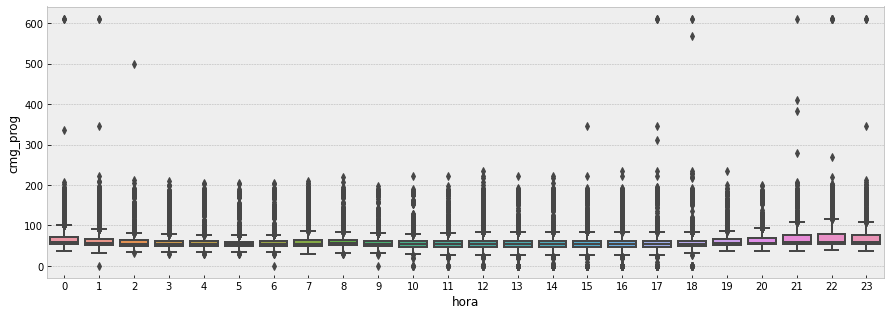

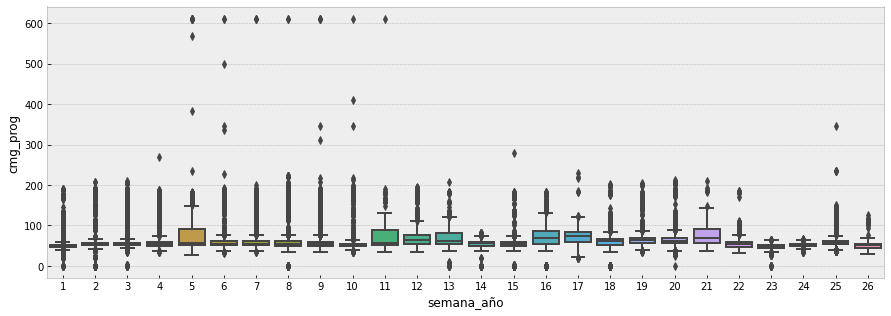

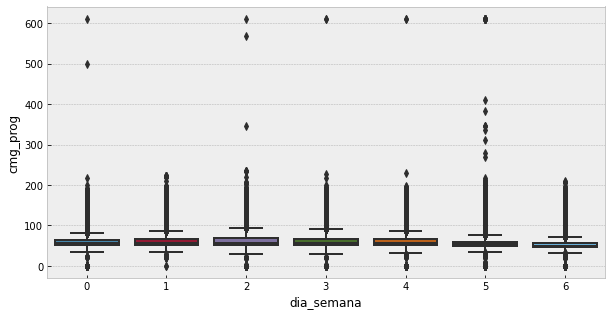

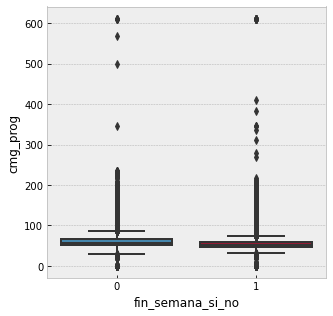

In [22]:
# Variable: 'cmg_prog'

for cat_var in cat_vars:
    multiple_boxplots(num_vars[1], cat_var)

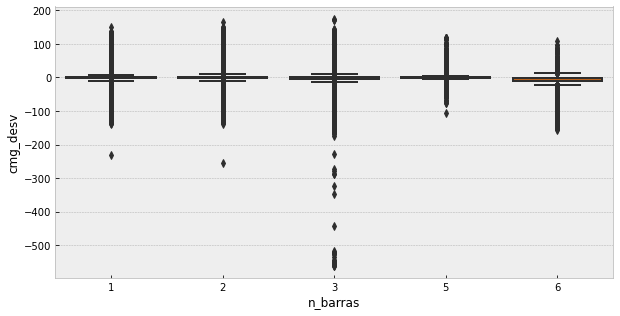

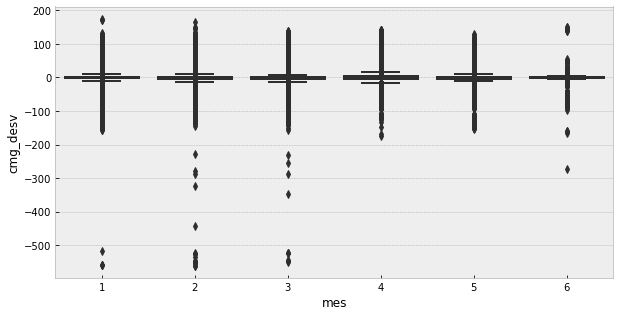

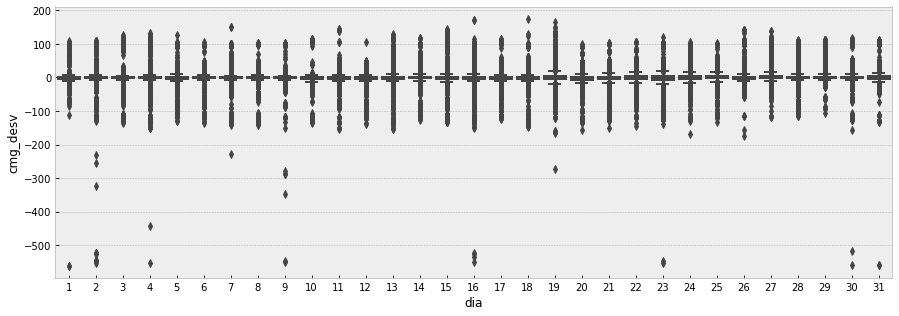

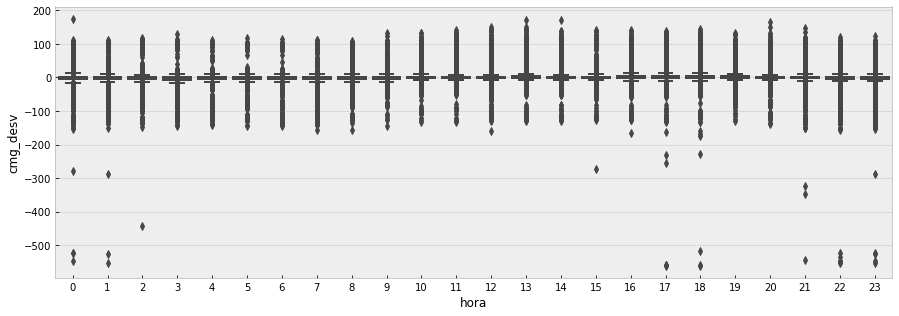

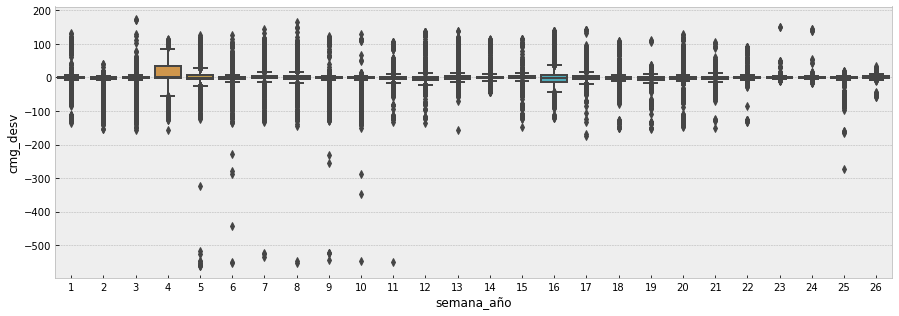

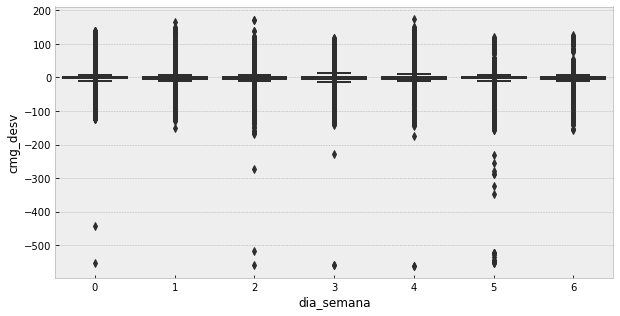

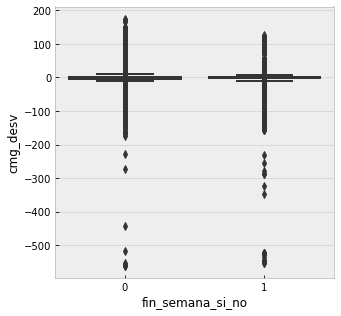

In [23]:
# Variable: 'cmg_desv'

for cat_var in cat_vars:
    multiple_boxplots(num_vars[2], cat_var)

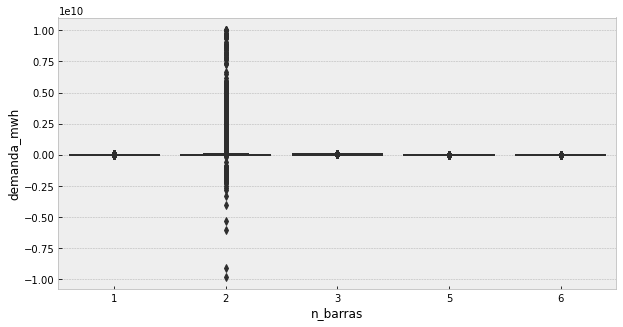

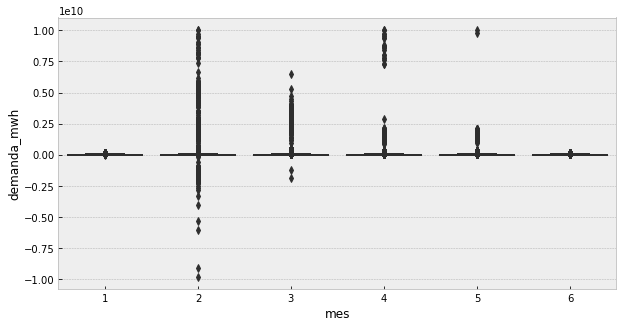

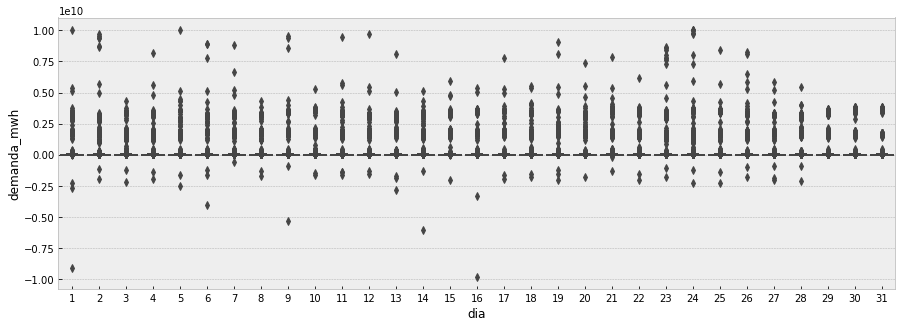

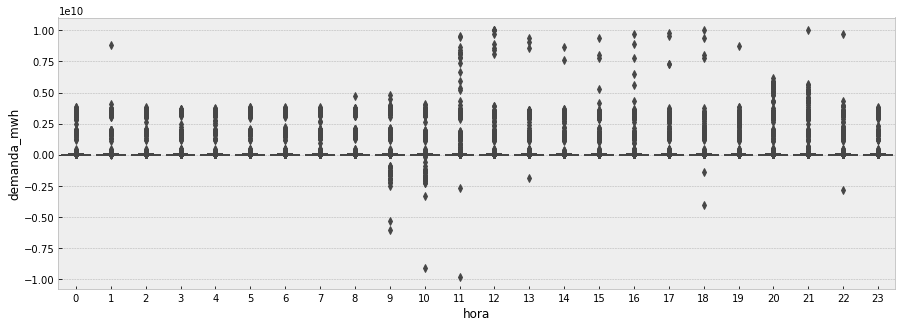

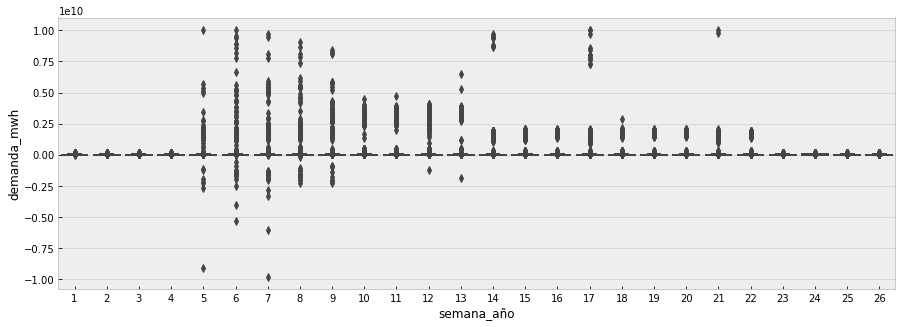

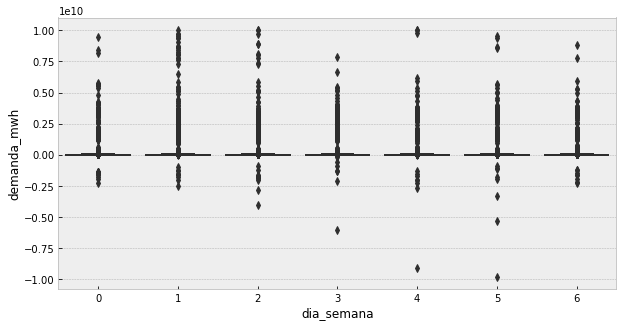

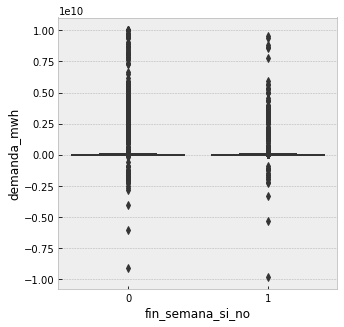

In [24]:
# Variable: 'demanda_mwh'

for cat_var in cat_vars:
    multiple_boxplots(num_vars[3], cat_var)

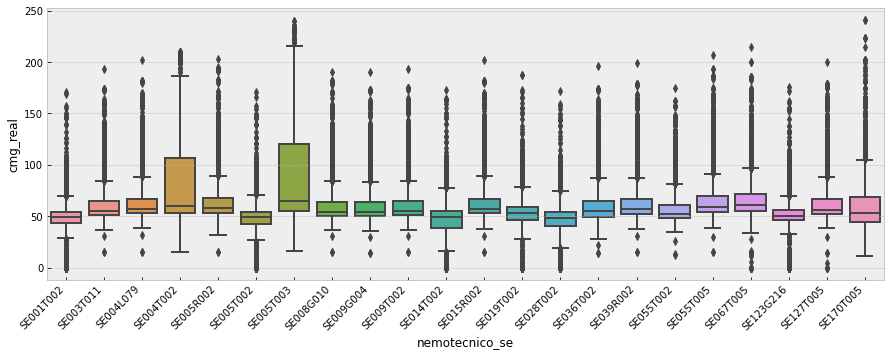

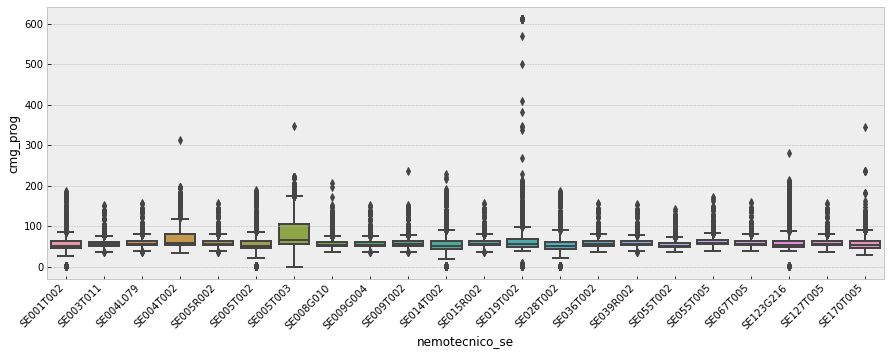

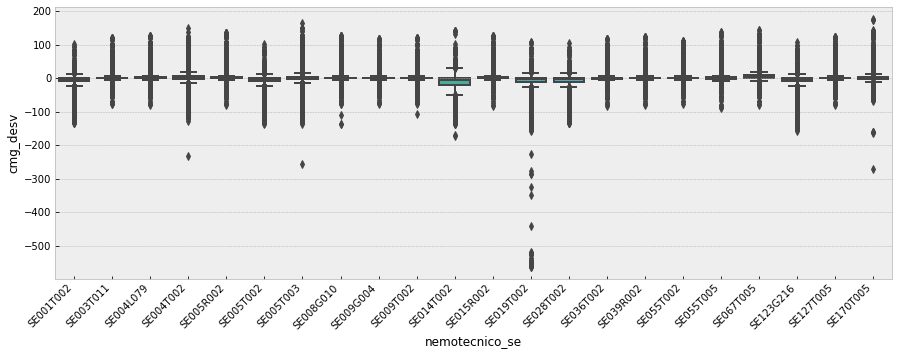

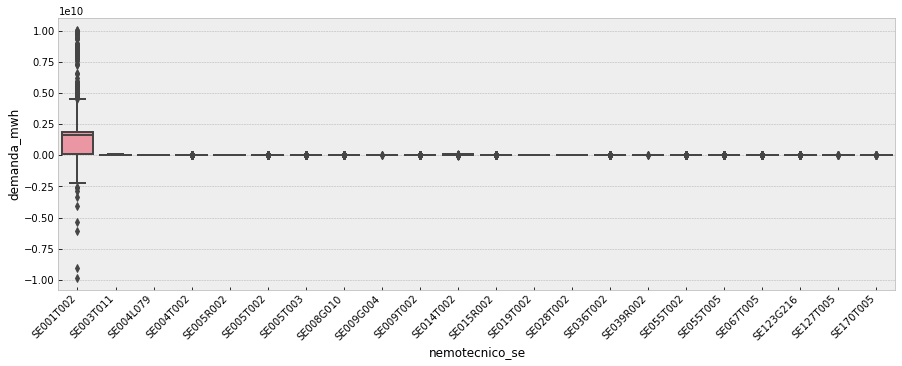

In [25]:
# Analyze all numeric variables categorizing by substation

for num_var in num_vars:
    multiple_boxplots(num_var, 'nemotecnico_se', rotate_xticks=True)

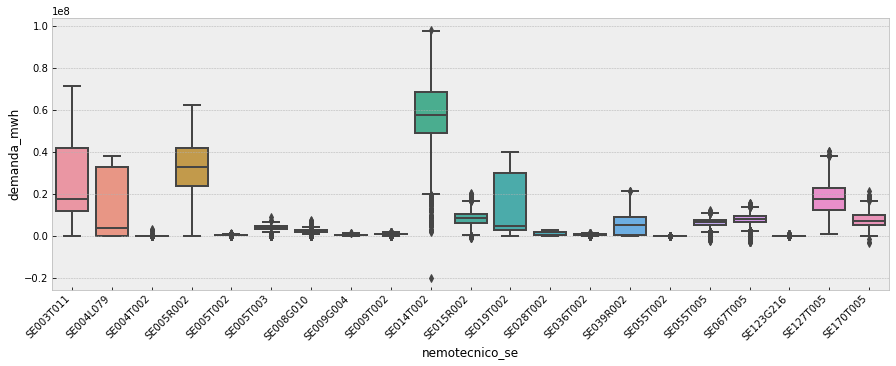

In [26]:
se_code_list = df['nemotecnico_se'].unique().tolist()[1:]

multiple_boxplots('demanda_mwh', 'nemotecnico_se', se_code_list=se_code_list, rotate_xticks=True)

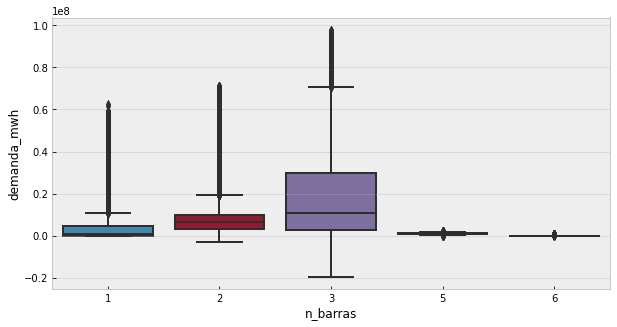

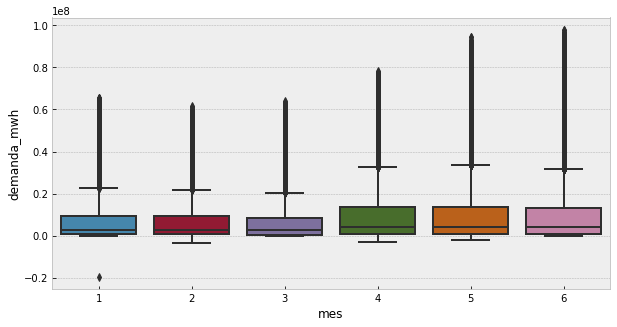

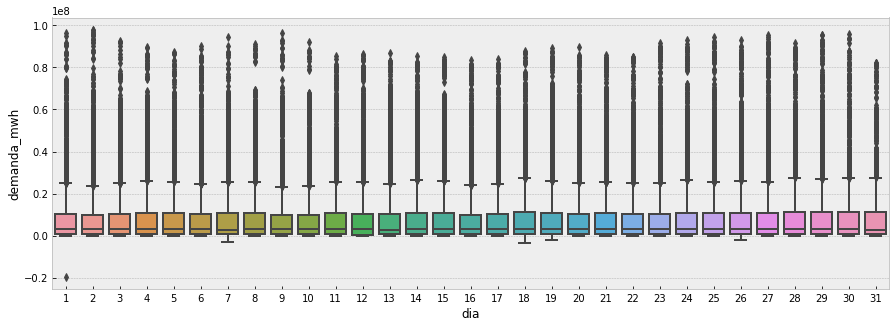

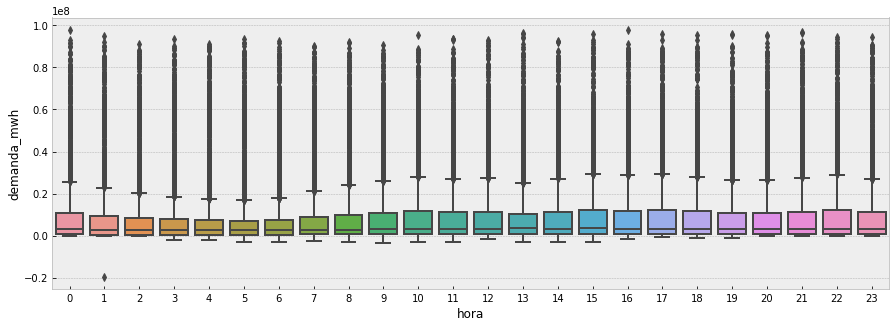

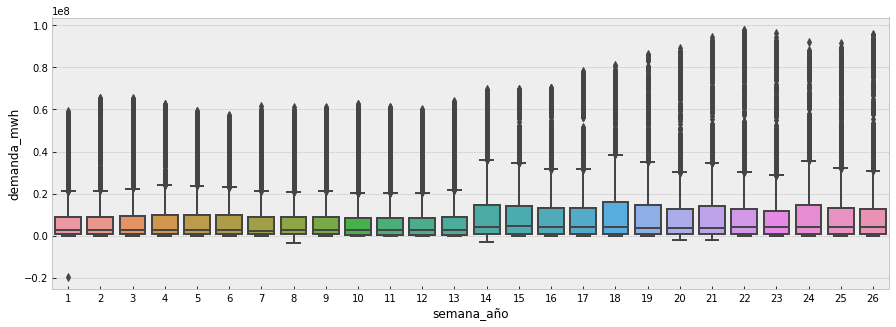

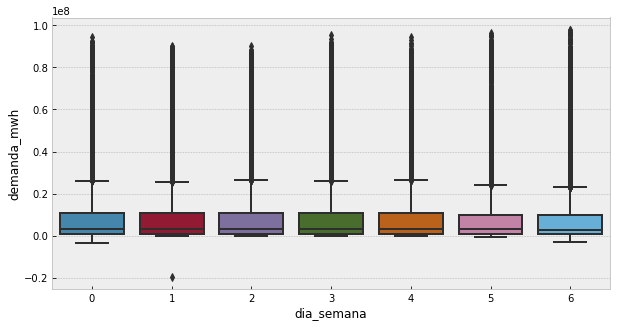

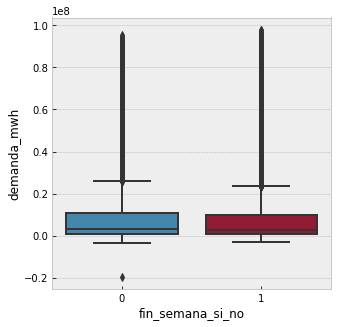

In [27]:
for cat_var in cat_vars:
    multiple_boxplots('demanda_mwh', cat_var, se_code_list=se_code_list)

### b. Using histograms

In [28]:
def multiple_histograms(num_var):
    fig, axes = plt.subplots(6, 4, figsize=(12, 16))
    se_code_list = df['nemotecnico_se'].unique().tolist()

    for ax, se_code in zip(axes.flatten(), se_code_list):
        series = df[df['nemotecnico_se']==se_code][num_var]
        sb.histplot(x=series, kde=True, ax=ax)
        ax.set_xlabel(se_code)
    
    fig.tight_layout()

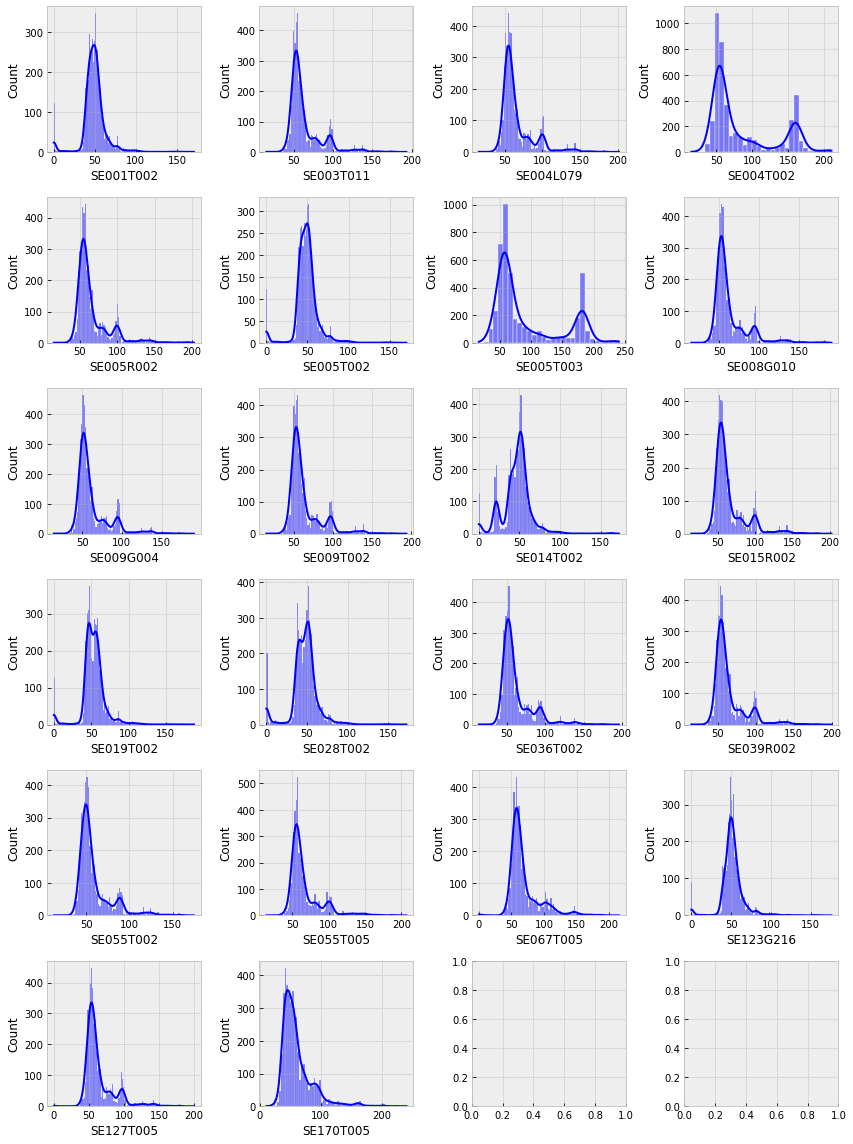

In [29]:
multiple_histograms('cmg_real')

### c. Time Series Heat Maps

In [30]:
def time_series_heatmap(se_code, num_var):
    
    data = df[
        (df['nemotecnico_se']==se_code)
    ][['fecha', 'dia_calendario', num_var]].sort_values(by='fecha')
    
    groups = data[['dia_calendario', num_var]].groupby(pd.Grouper(key='dia_calendario'))
    days = pd.DataFrame()
    for name,group in groups:
        days[name] = group[num_var].values
    
    fig = plt.figure(figsize=(18,4))
    ax = fig.add_subplot(1, 1, 1)
    i = ax.imshow(days, interpolation=None, aspect='auto', cmap='inferno')
    ax.set_title('Time series heatmap for {} - Substation {}'.format(num_var, se_code))
    ax.set_xlabel('Calendar days')
    ax.set_ylabel('Hours')
    ax.set_xticks(ticks=np.arange(0, 181, 30))
    ax.set_yticks(ticks=np.arange(0, 24, 6))
    fig.colorbar(i)
    plt.show()

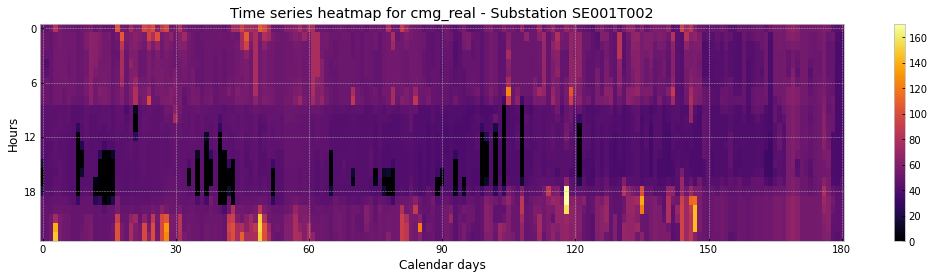

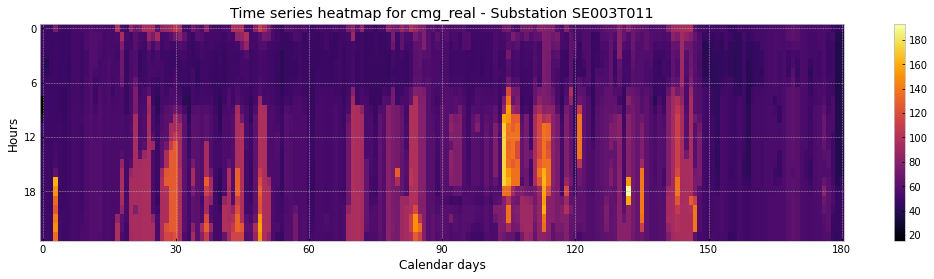

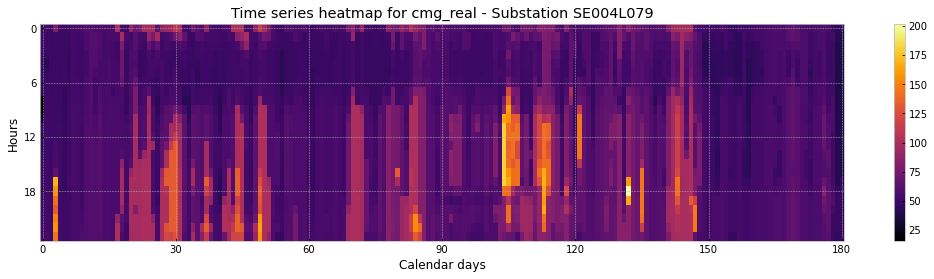

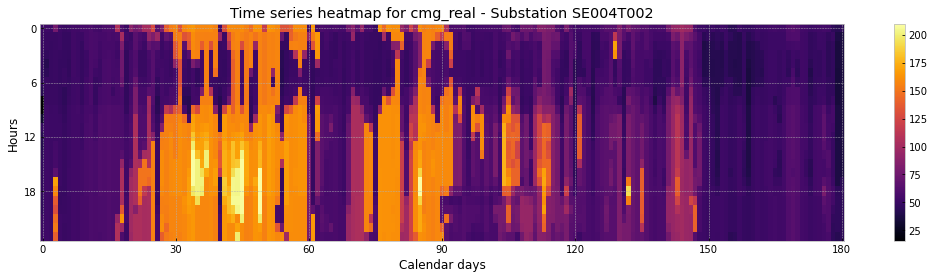

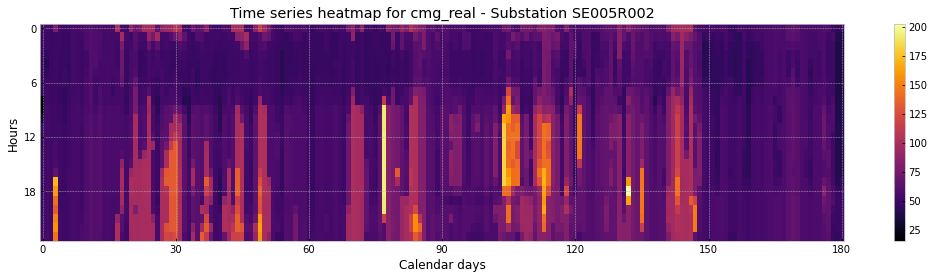

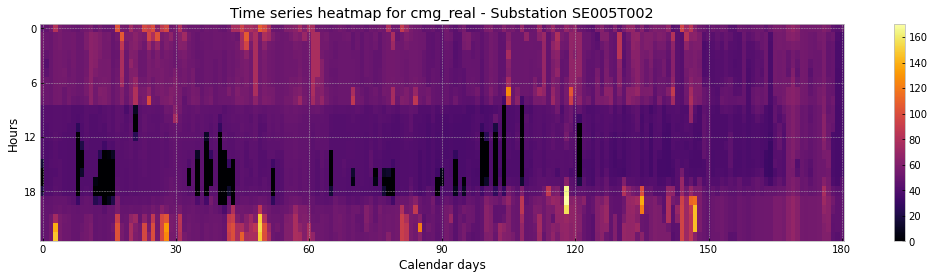

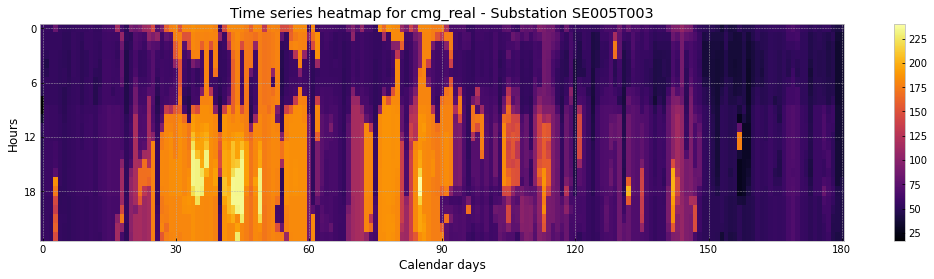

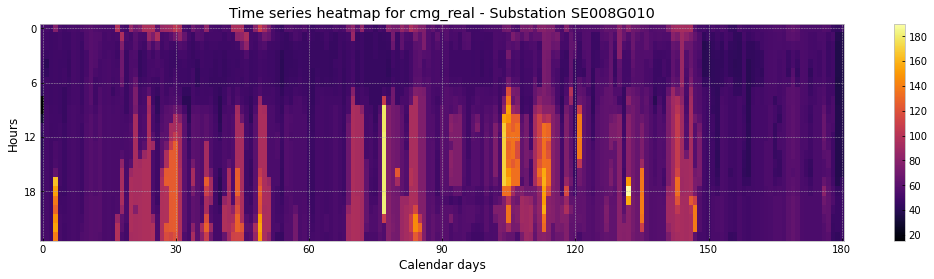

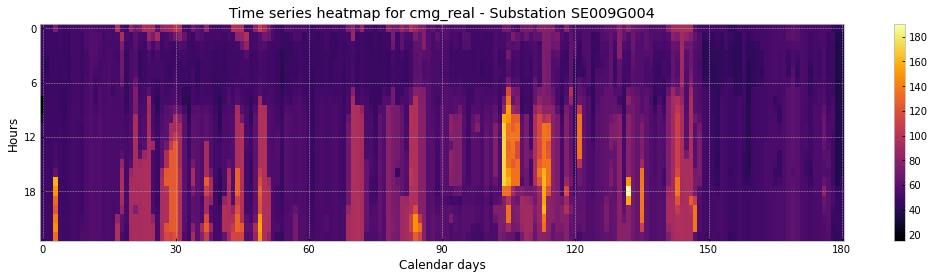

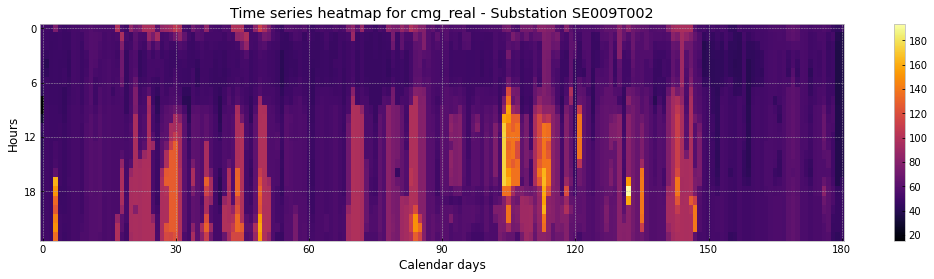

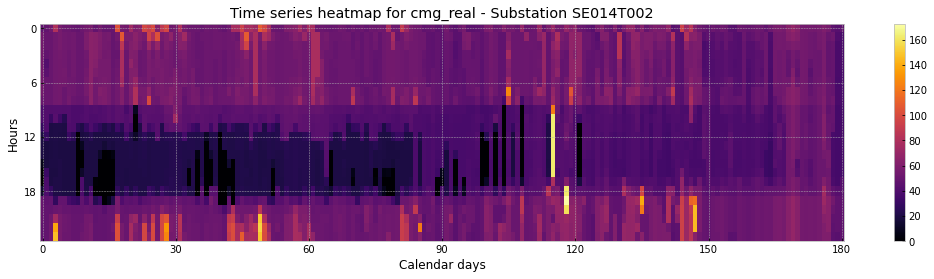

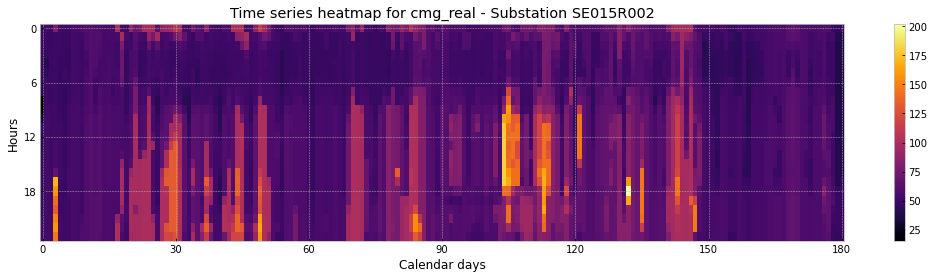

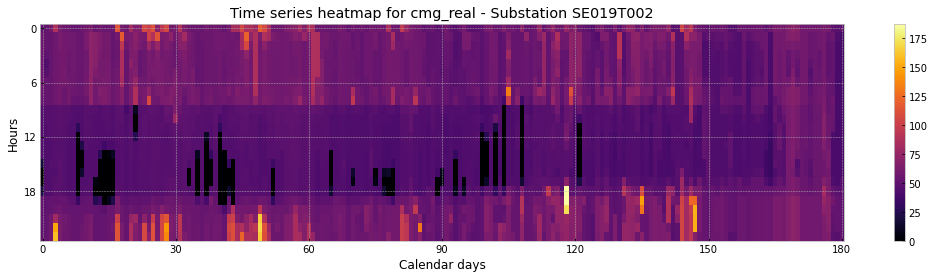

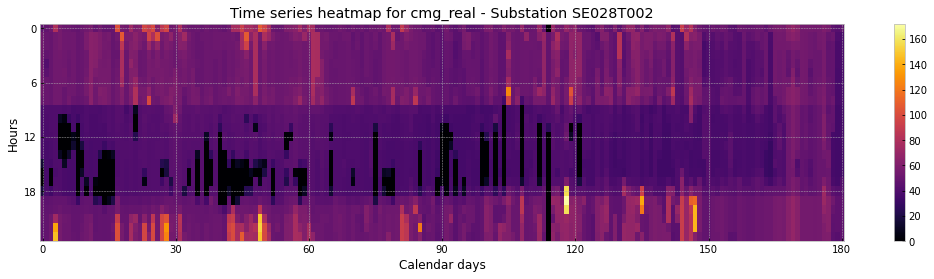

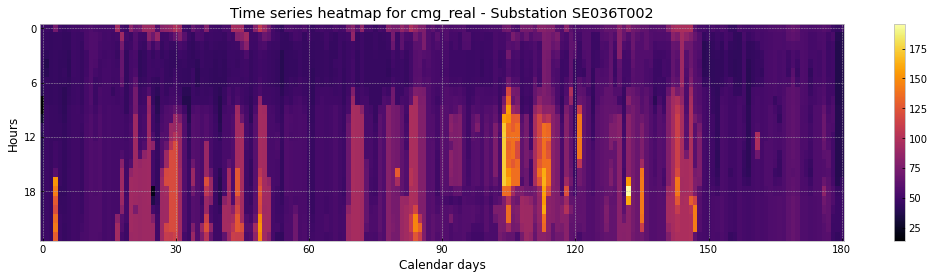

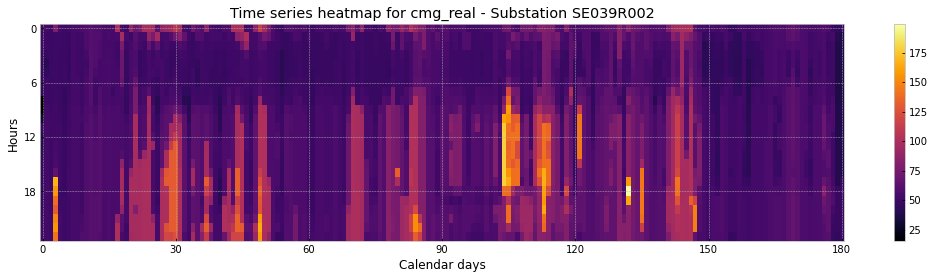

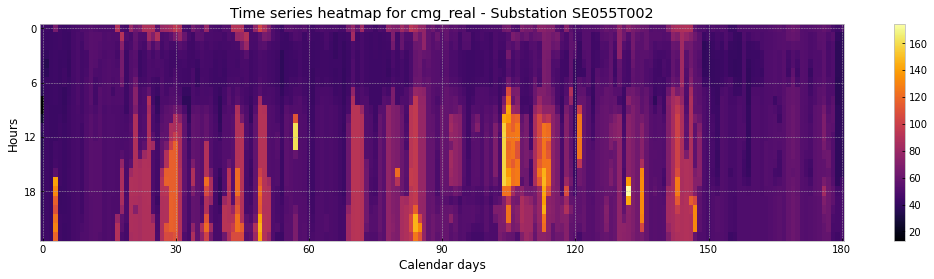

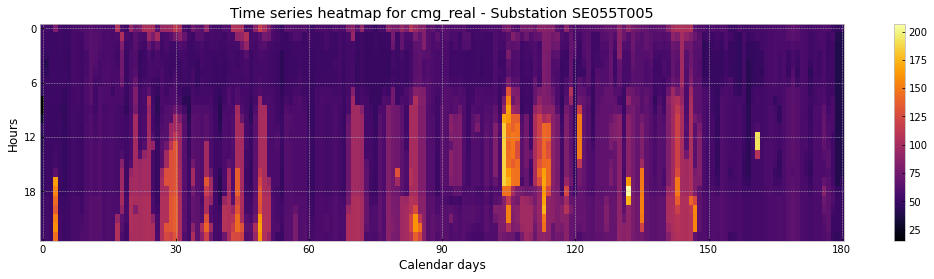

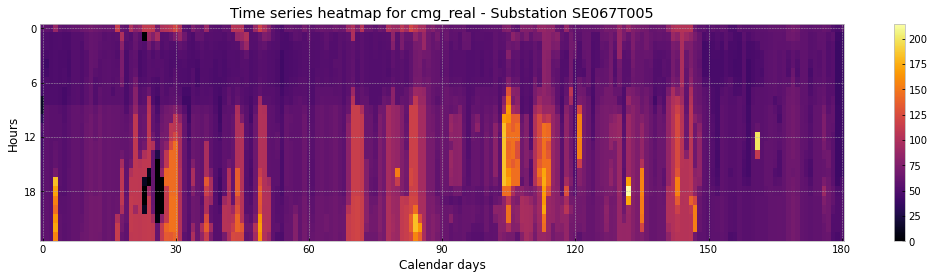

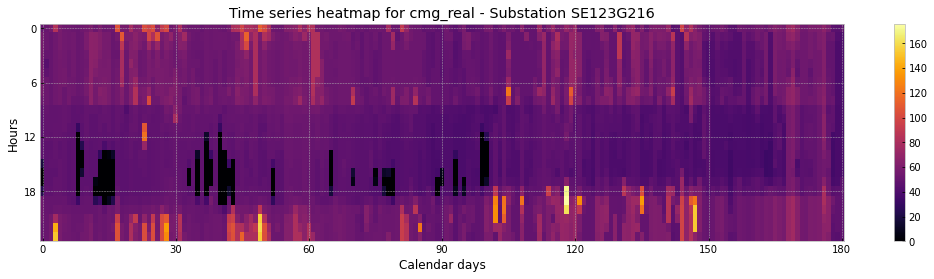

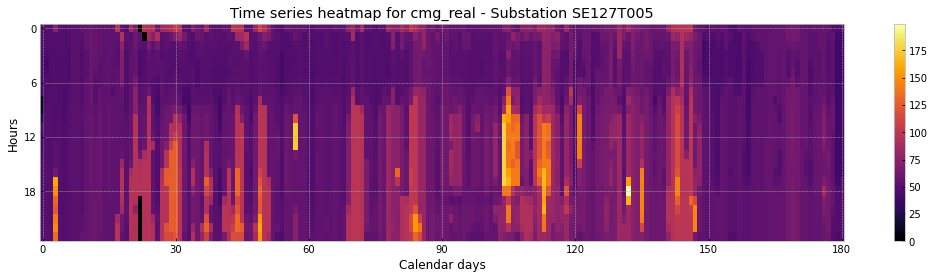

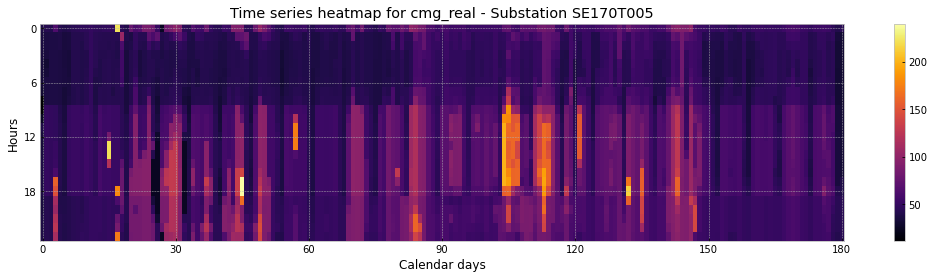

In [31]:
for sub in df['nemotecnico_se'].unique():
    time_series_heatmap(sub, 'cmg_real')